── Dataset Info ──
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 550068 entries, 0 to 550067
Data columns (total 10 columns):
 #   Column                      Non-Null Count   Dtype 
---  ------                      --------------   ----- 
 0   User_ID                     550068 non-null  int64 
 1   Product_ID                  550068 non-null  object
 2   Gender                      550068 non-null  object
 3   Age                         550068 non-null  object
 4   Occupation                  550068 non-null  int64 
 5   City_Category               550068 non-null  object
 6   Stay_In_Current_City_Years  550068 non-null  object
 7   Marital_Status              550068 non-null  int64 
 8   Product_Category            550068 non-null  int64 
 9   Purchase                    550068 non-null  int64 
dtypes: int64(5), object(5)
memory usage: 42.0+ MB
None

── Summary Statistics ──
            User_ID     Occupation  Marital_Status  Product_Category  \
count  5.500680e+05  550068.0000

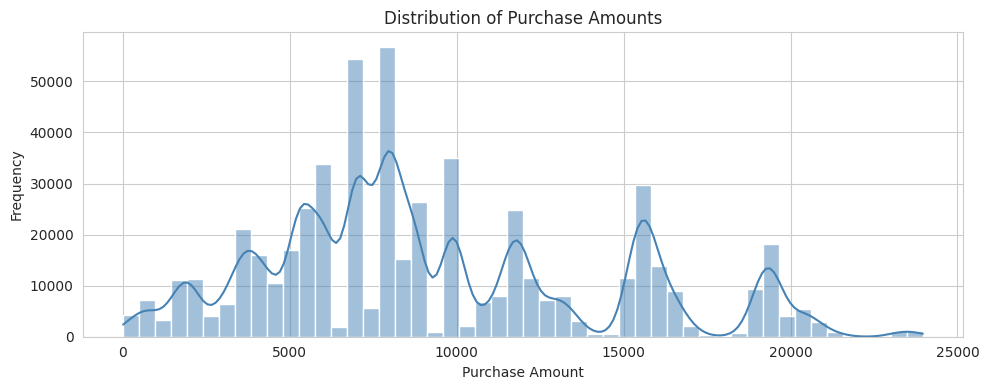

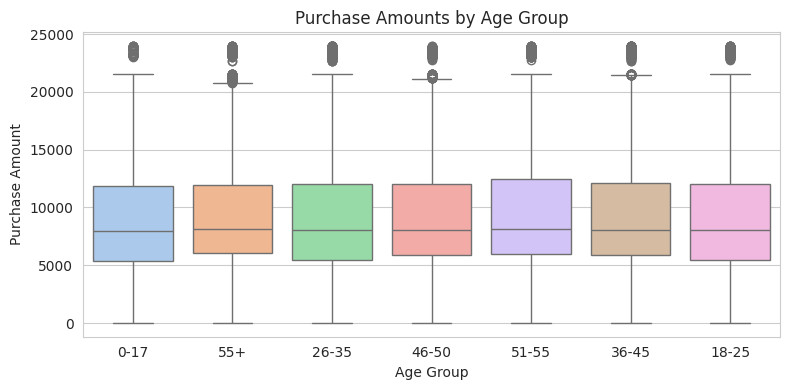

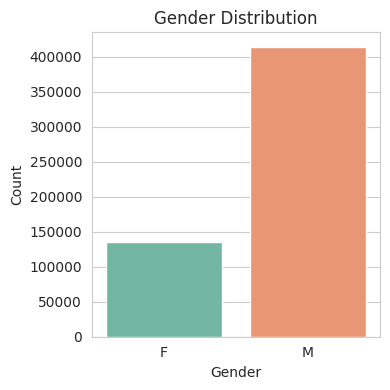

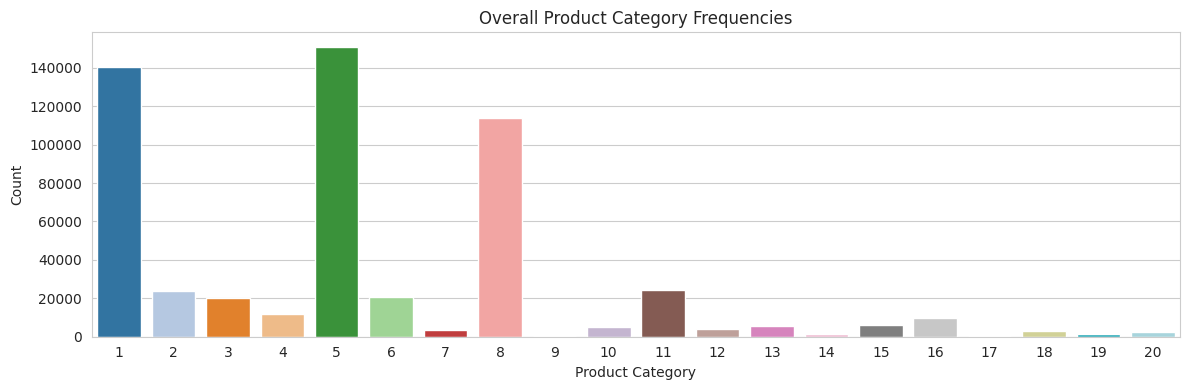

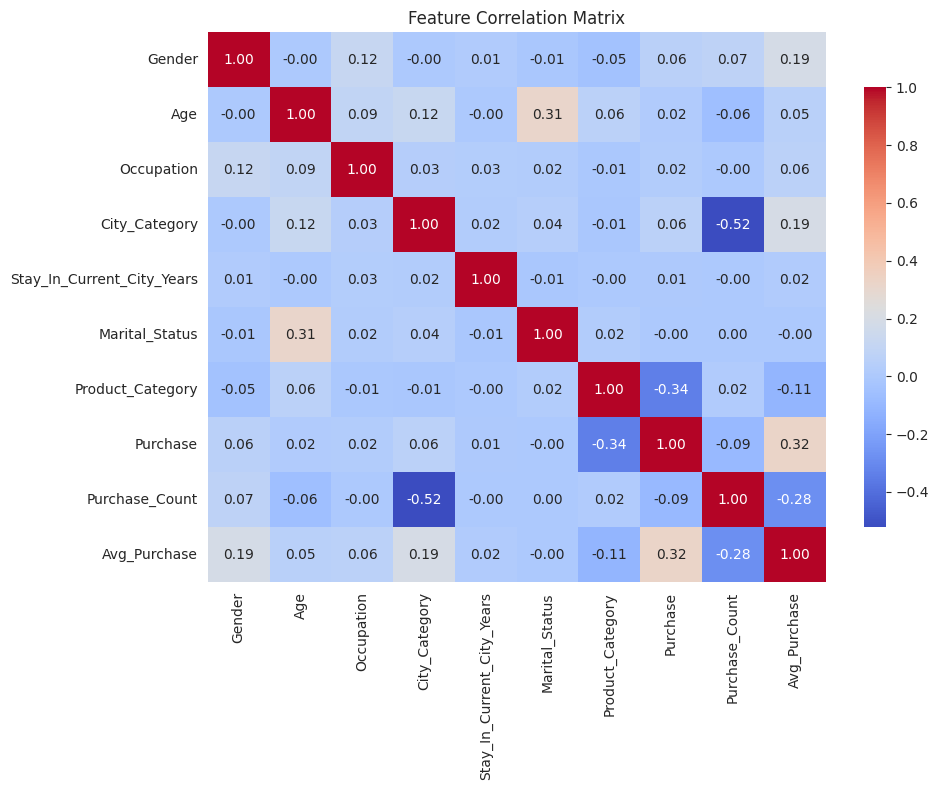


Training set: (440054, 9), Test set: (110014, 9)

Logistic Regression
  CV Accuracy: 0.4999
  Test Accuracy: 0.5011
              precision    recall  f1-score   support

           0       0.56      0.81      0.66     28076
           1       0.00      0.00      0.00      4773
           2       0.00      0.00      0.00      4043
           3       0.24      0.22      0.23      2351
           4       0.48      0.78      0.59     30187
           5       0.50      0.00      0.00      4093
           6       0.00      0.00      0.00       744
           7       0.43      0.28      0.34     22785
           8       0.00      0.00      0.00        82
           9       0.98      0.30      0.46      1025
          10       0.00      0.00      0.00      4857
          11       0.60      0.21      0.31       789
          12       0.62      0.93      0.74      1110
          13       0.00      0.00      0.00       304
          14       0.00      0.00      0.00      1258
          15      

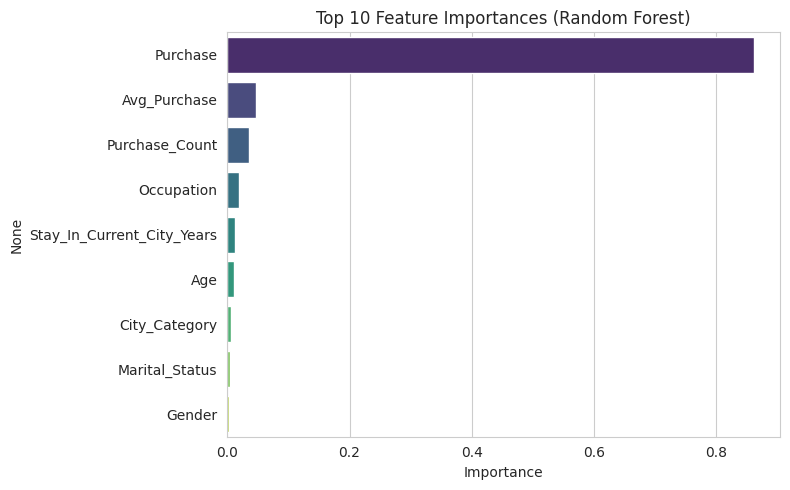

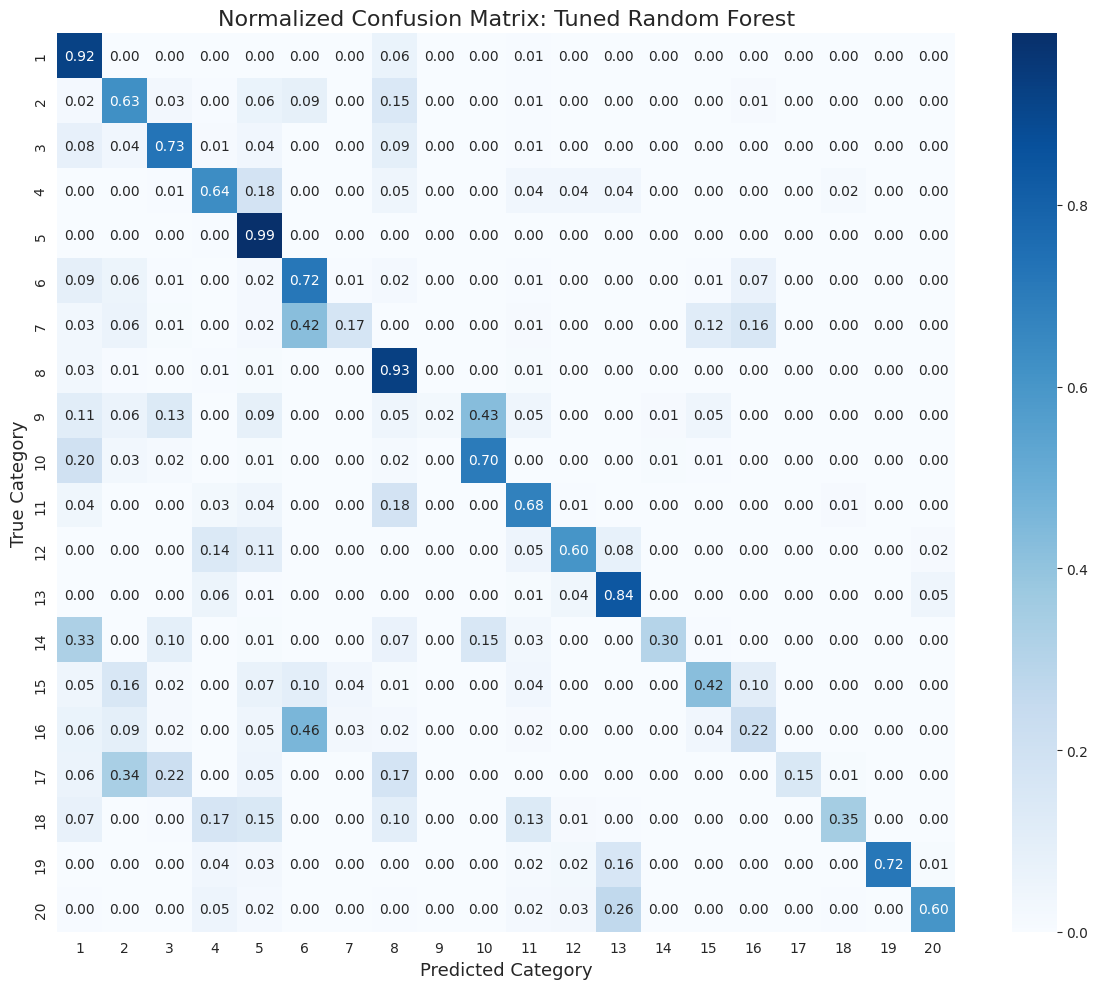

In [ ]:
# ──────────────────────────────────────────────────────────────────────────────
# Chapter 4: Source Code for Multi‑Class Product Category Prediction
# (Using zero-indexed labels internally but displaying 1–20 in evaluation)
 ──────────────────────────────────────────────────────────────────────────────

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# 1) LOAD & INSPECT DATA
df = pd.read_csv("/content/walmart.csv")  # Adjust the path if needed
print("── Dataset Info ──")
print(df.info())
print("\n── Summary Statistics ──")
print(df.describe())
print("\n── Missing Values ──")
print(df.isnull().sum())

# 2) RAW DISTRIBUTIONS
plt.figure(figsize=(10,4))
sns.histplot(df['Purchase'], bins=50, kde=True, color="steelblue")
plt.title("Distribution of Purchase Amounts")
plt.xlabel("Purchase Amount")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
sns.boxplot(x='Age', y='Purchase', data=df, palette="pastel")
plt.title("Purchase Amounts by Age Group")
plt.xlabel("Age Group")
plt.ylabel("Purchase Amount")
plt.tight_layout()
plt.show()

plt.figure(figsize=(4,4))
sns.countplot(x='Gender', data=df, palette="Set2")
plt.title("Gender Distribution")
plt.xlabel("Gender")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) PREPROCESSING
# Convert '4+' in Stay_In_Current_City_Years to integer 4
df['Stay_In_Current_City_Years'] = df['Stay_In_Current_City_Years']\
    .replace({'4+':'4'}).astype(int)

# Label‑encode categorical features
le = LabelEncoder()
for col in ['Gender', 'Age', 'City_Category']:
    df[col] = le.fit_transform(df[col])

# 4) FEATURE ENGINEERING
# Add user-level features: Purchase_Count and Avg_Purchase
user_agg = df.groupby('User_ID')['Purchase']\
             .agg(Purchase_Count='count', Avg_Purchase='mean')\
             .reset_index()
df = df.merge(user_agg, on='User_ID', how='left')

# 5) CATEGORY DISTRIBUTION & CORRELATION PLOT
plt.figure(figsize=(12,4))
sns.countplot(x='Product_Category', data=df, palette="tab20")
plt.title("Overall Product Category Frequencies")
plt.xlabel("Product Category")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,8))
corr = df.drop(columns=['User_ID', 'Product_ID']).corr()
sns.heatmap(corr, annot=True, fmt=".2f", cmap="coolwarm", cbar_kws={'shrink':0.8})
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()

# 6) PREPARE MODEL INPUT
# Drop identifiers and the true label; note: we shift labels from 1–20 to 0–19 for training
X = df.drop(columns=['User_ID', 'Product_ID', 'Product_Category'])
y = df['Product_Category'] - 1

# 7) TRAIN/TEST SPLIT
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, random_state=42, stratify=y
)
print(f"\nTraining set: {X_train.shape}, Test set: {X_test.shape}")

# 8) MODEL PIPELINES & EVALUATION

# 8.1 Logistic Regression
logistic_pipe = Pipeline([
    ('scale', StandardScaler()),
    ('clf', LogisticRegression(
        multi_class='multinomial', solver='lbfgs', max_iter=500, random_state=42))
])
cv_score_logistic = cross_val_score(logistic_pipe, X_train, y_train, cv=3, scoring='accuracy').mean()
logistic_pipe.fit(X_train, y_train)
preds_logistic = logistic_pipe.predict(X_test)
test_acc_logistic = accuracy_score(y_test, preds_logistic)
print("\nLogistic Regression")
print(f"  CV Accuracy: {cv_score_logistic:.4f}")
print(f"  Test Accuracy: {test_acc_logistic:.4f}")
print(classification_report(y_test, preds_logistic, zero_division=0))

# 8.2 Decision Tree
tree_pipe = Pipeline([
    ('clf', DecisionTreeClassifier(random_state=42))
])
cv_score_tree = cross_val_score(tree_pipe, X_train, y_train, cv=3, scoring='accuracy').mean()
tree_pipe.fit(X_train, y_train)
preds_tree = tree_pipe.predict(X_test)
test_acc_tree = accuracy_score(y_test, preds_tree)
print("\nDecision Tree")
print(f"  CV Accuracy: {cv_score_tree:.4f}")
print(f"  Test Accuracy: {test_acc_tree:.4f}")
print(classification_report(y_test, preds_tree, zero_division=0))

# 8.3 Random Forest
rf_pipe = Pipeline([
    ('clf', RandomForestClassifier(n_estimators=100, random_state=42))
])
cv_score_rf = cross_val_score(rf_pipe, X_train, y_train, cv=3, scoring='accuracy').mean()
rf_pipe.fit(X_train, y_train)
preds_rf = rf_pipe.predict(X_test)
test_acc_rf = accuracy_score(y_test, preds_rf)
print("\nRandom Forest")
print(f"  CV Accuracy: {cv_score_rf:.4f}")
print(f"  Test Accuracy: {test_acc_rf:.4f}")
print(classification_report(y_test, preds_rf, zero_division=0))

# 8.4 XGBoost
xgb_pipe = Pipeline([
    ('clf', XGBClassifier(
        eval_metric='mlogloss', use_label_encoder=False, random_state=42))
])
cv_score_xgb = cross_val_score(xgb_pipe, X_train, y_train, cv=3, scoring='accuracy').mean()
xgb_pipe.fit(X_train, y_train)
preds_xgb = xgb_pipe.predict(X_test)
test_acc_xgb = accuracy_score(y_test, preds_xgb)
print("\nXGBoost")
print(f"  CV Accuracy: {cv_score_xgb:.4f}")
print(f"  Test Accuracy: {test_acc_xgb:.4f}")
print(classification_report(y_test, preds_xgb))

# 9) RANDOMIZED SEARCH ON RANDOM FOREST
param_dist = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5, 10]
}
rsearch = RandomizedSearchCV(
    rf_pipe, param_dist,
    n_iter=6, cv=3, scoring='accuracy',
    random_state=42, n_jobs=-1
)
rsearch.fit(X_train, y_train)
best_rf = rsearch.best_estimator_
print("\nTuned Random Forest Params:", rsearch.best_params_)
pred_rf = best_rf.predict(X_test)
print("Tuned RF Test Accuracy:", accuracy_score(y_test, pred_rf))
print("\nClassification Report (Tuned RF):")
print(classification_report(y_test, pred_rf, zero_division=0))

# 10) FEATURE IMPORTANCE (Tuned RF)
importances = best_rf.named_steps['clf'].feature_importances_
feat_names = X.columns
imp_df = pd.Series(importances, index=feat_names).sort_values(ascending=False)
plt.figure(figsize=(8,5))
sns.barplot(x=imp_df.values[:10], y=imp_df.index[:10], palette="viridis")
plt.title("Top 10 Feature Importances (Random Forest)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 11) CONFUSION MATRIX FOR TUNED RF
# Convert labels back to the original range (1–20) for display
y_test_disp = y_test + 1
pred_rf_disp = pred_rf + 1
cm = confusion_matrix(y_test_disp, pred_rf_disp, normalize='true')
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt=".2f", cmap="Blues", cbar=True,
            xticklabels=np.arange(1, 21), yticklabels=np.arange(1, 21))
plt.title("Normalized Confusion Matrix: Tuned Random Forest", fontsize=16)
plt.xlabel("Predicted Category", fontsize=13)
plt.ylabel("True Category", fontsize=13)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.show()


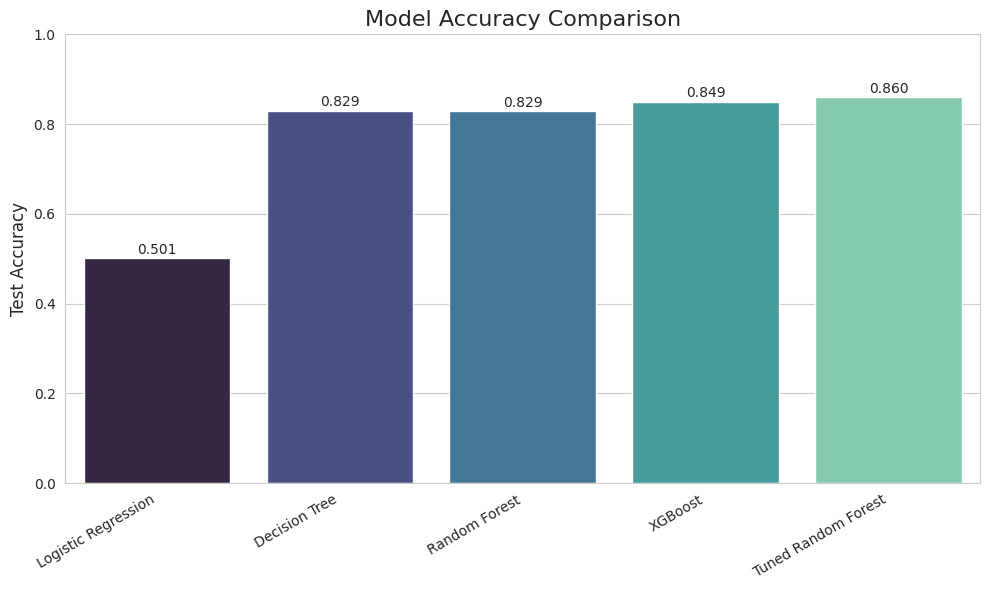

In [ ]:
# 12) MODEL COMPARISON CHART

# Collect test accuracy scores
model_names = ['Logistic Regression', 'Decision Tree', 'Random Forest', 'XGBoost', 'Tuned Random Forest']
test_accuracies = [test_acc_logistic, test_acc_tree, test_acc_rf, test_acc_xgb, accuracy_score(y_test, pred_rf)]

# Create bar plot
plt.figure(figsize=(10,6))
sns.barplot(x=model_names, y=test_accuracies, palette='mako')
plt.title("Model Accuracy Comparison", fontsize=16)
plt.ylabel("Test Accuracy", fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=30, ha='right')
for i, acc in enumerate(test_accuracies):
    plt.text(i, acc + 0.01, f"{acc:.3f}", ha='center', fontsize=10)

plt.tight_layout()
plt.show()
